<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

please watch : https://www.youtube.com/watch?v=581X9wsnWJs  => CNRS video YT 27:26 min complet explanation  about CNN

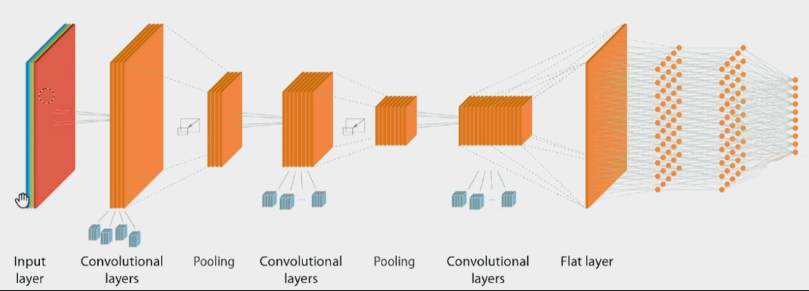

# <!-- TITLE --> 16 - Simple classification with CNN - [MNIST2]
<!-- DESC --> An example of classification using a convolutional neural network for the famous MNIST dataset
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Recognizing handwritten numbers
 - Understanding the principle of a classifier DNN network 
 - Implementation with Keras 


The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) is a must for Deep Learning.  
It consists of 60,000 small images of handwritten numbers for learning and 10,000 for testing.


## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Create a model
 - Train the model
 - Evaluate the result


## Step 1 - installation des packages utiles

In [12]:
# MODIFICATION : Version simplifiée sans dépendance à fidle ni gestion de dossiers inutiles

# Installer les packages nécessaires (à activer si sur Google Colab)
# !pip install torch torchvision torchaudio keras numpy matplotlib scikit-learn

import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras
import numpy as np
import matplotlib.pyplot as plt


Verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

Override parameters (batch mode) - Just forget this cell

## Step 2 - Récupération des données
MNIST is one of the most famous historic dataset.  
Include in [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("x_train : ",x_train.shape)
print("y_train : ",y_train.shape)
print("x_test  : ",x_test.shape)
print("y_test  : ",y_test.shape)

x_train :  (60000, 28, 28)
y_train :  (60000,)
x_test  :  (10000, 28, 28)
y_test  :  (10000,)


In [14]:
x_train[1].shape # image 2, 28 lignes par 28 colonnes de valeurs entre 0 et 255 Noir->Blanc

(28, 28)

In [15]:
# ici nos images ont 1 seul canal (niveau de gris)

x_train = x_train.reshape(-1,28,28,1) # ajoute 1 dimension pour le canal de niveaux de gris
# -1 : cette dimension sera calculée automatiquement pour inclure tous les échantillons (60000 pour x_train et 10000 pour x_test).
# 28, 28 : la hauteur et la largeur de chaque image.
# 1 : le nombre de canaux, qui est 1 pour les images en niveaux de gris.

x_test  = x_test.reshape(-1,28,28,1)

print("x_train : ",x_train.shape)
print("y_train : ",y_train.shape)
print("x_test  : ",x_test.shape)
print("y_test  : ",y_test.shape)

# donne pour x_train : 60000 image en 28 x 28 sur 1 canal de couleur

x_train :  (60000, 28, 28, 1)
y_train :  (60000,)
x_test  :  (10000, 28, 28, 1)
y_test  :  (10000,)


## Step 3 - Preparing the data

In [16]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

xmax=x_train.max()
x_train = x_train / xmax
x_test  = x_test  / xmax

print('After normalization  : Min={}, max={}'.format(x_train.min(),x_train.max()))

Before normalization : Min=0, max=255
After normalization  : Min=0.0, max=1.0


### Have a look

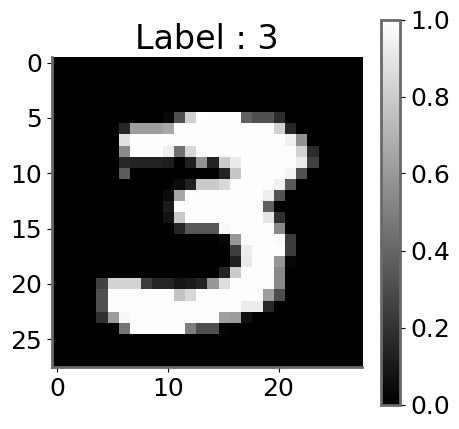

In [17]:
# Afficher une image unique
plt.figure(figsize=(5, 5))
plt.imshow(x_train[27].squeeze(), cmap='gray')  # Utilisez .squeeze() pour supprimer la dimension de canal
plt.colorbar()
plt.title(f"Label : {y_train[27]}")
#plt.savefig('one-digit.png')  # Sauvegarder l'image
plt.show()


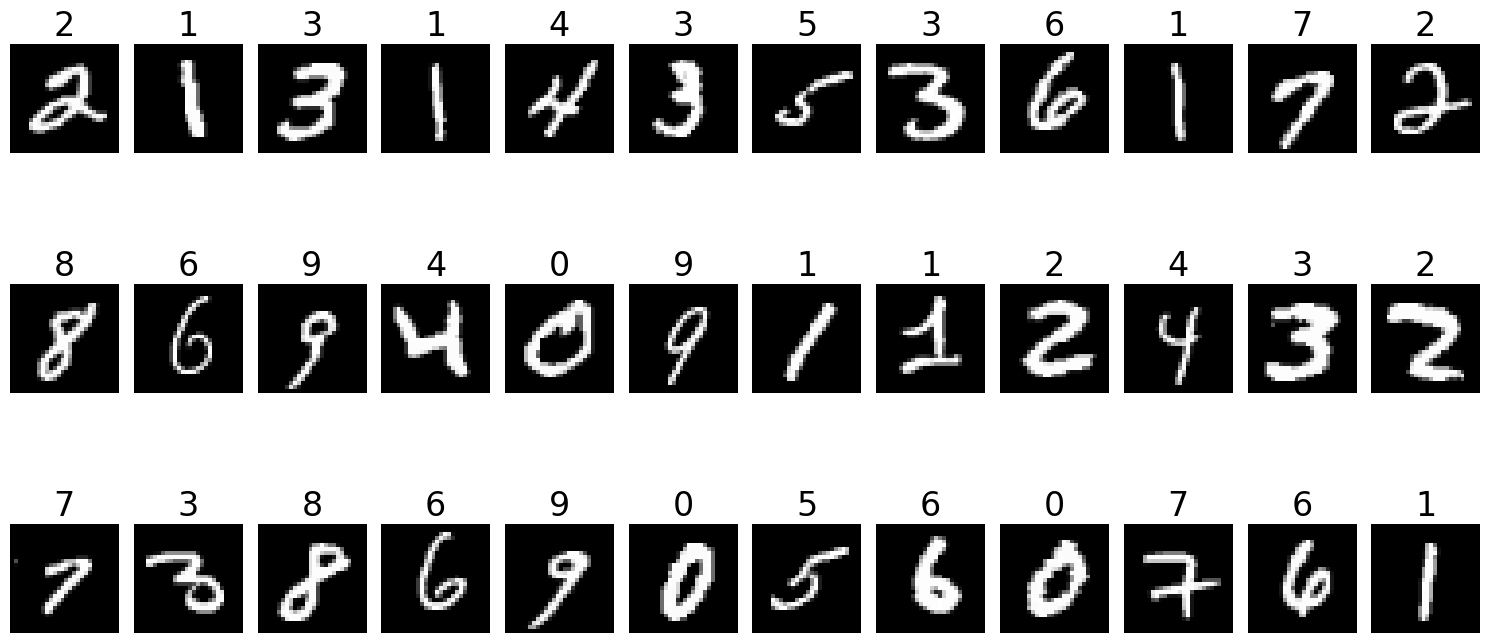

In [18]:
# Définir les indices et paramètres d'affichage
indices = range(5, 41)
columns = 12
rows = (len(indices) + columns - 1) // columns  # Calculer le nombre de lignes nécessaire

plt.figure(figsize=(15, 8))  # Ajustez la taille de la figure pour correspondre aux images

for i, idx in enumerate(indices):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(x_train[idx].squeeze(), cmap='gray')
    plt.title(f"{y_train[idx]}")  # on affiche les étiquettes y de nos datas X
    plt.axis('off')  # Masquer les axes pour un affichage plus propre

plt.tight_layout()
#plt.savefig('many-digits.png')  # Sauvegarder l'image
plt.show()


## Step 4 - Create model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

 ## 🌐 Comprendre les concepts clés d’un réseau de neurones convolutif (CNN)

Voici les notions fondamentales utilisées dans notre modèle CNN :

---

### 🔹 <span style="color:royalblue"><b>Convolution</b></span>
La convolution est une opération mathématique qui applique un **filtre (ou kernel)** sur une image pour en extraire des **caractéristiques locales** (bords, motifs...).  
On glisse le filtre sur l'image (comme une loupe) et on calcule une somme pondérée des pixels.

- <span style="color:orange"><b>Padding</b></span> : ajoute une bordure autour de l'image d'origine pour **conserver sa taille** après convolution.  
  - Exemple : un padding `same` conserve les dimensions.
- <span style="color:teal"><b>Strides</b></span> : définit le **pas de déplacement** du filtre.  
  - Un stride de `1` glisse pixel par pixel, `2` saute 1 pixel à chaque fois → réduction de taille.

---

### 🔹 <span style="color:seagreen"><b>Pooling</b></span>
Le pooling réduit la dimension d’une image en prenant une valeur résumée (souvent **max ou moyenne**) dans une petite zone.  
Cela diminue le **nombre de paramètres** et rend le modèle **plus robuste** aux petites variations de position.

- Exemple : <span style="color:seagreen"><b>MaxPooling(2,2)</b></span> prend le maximum sur une zone de 2×2 pixels.

---

### 🔹 <span style="color:darkviolet"><b>Flat Layer (Flatten)</b></span>
Après les convolutions et poolings, les images deviennent de petits **blocs multidimensionnels**.  
La couche `Flatten` transforme ce **volume** (ex : 7×7×16) en **vecteur linéaire** (ex : 784) pour l'envoyer dans une couche dense (classique).

---

### 🔹 <span style="color:brown"><b>Kernel</b></span>
Un **kernel** est un petit tableau de poids (ex : 3×3) appliqué à chaque position de l'image.  
Il agit comme un **filtre** apprenant à détecter une caractéristique (ex : bord horizontal, texture...).

Chaque neurone convolutif apprend son propre **kernel** pendant l'entraînement.

---

### 🔹 <span style="color:crimson"><b>Dropout</b></span>
Technique de régularisation : pendant l'entraînement, une fraction aléatoire des neurones est **désactivée** (mise à zéro).  
Cela empêche certains neurones de devenir trop dominants et **limite le surapprentissage (overfitting)**.

- Exemple : `Dropout(0.5)` désactive **50 % des neurones** à chaque itération (pendant le training uniquement).

---


In [19]:
model = keras.models.Sequential()                                       # on instancie notre modèle de convolution en mode séquentiel (pas à pas)

model.add( keras.layers.Input((28,28,1)) )                              # on y ajoute notre 1ere couche d'entrée sur des objets de taille (28, 28, 1)

model.add( keras.layers.Conv2D(8, (3,3),  activation='relu') )          # on ajoute 8 couches convolutives en sortie, avec kernel (3x3) et un sigma d'activation RELU (conv 2D car matrice 28x28, conv 1D pour les courbes ...)
model.add( keras.layers.MaxPooling2D((2,2)))                            # on réduit par 2 sur chaque dimension nos plans de sortie avec max pooling de kernel (2,2) => images deviennent (14,14) si padding (12,12) sinon
model.add( keras.layers.Dropout(0.2))                                   # nouveau, que pour l'apprentissage, force les sortie à devenir 0 sur 20% des sortie (0.2) de façon aléatoire ! 
                                                                        # => pour pas que certains neurones prennent trop d'importance sur d'autres neurones = on déactive des neurones au hasard et tous sont déactivés 1 fois

model.add( keras.layers.Conv2D(16, (3,3), activation='relu') )          # on refait notre convolution mais avec 16 couches de sorties cette fois
model.add( keras.layers.MaxPooling2D((2,2)))                            # on redivise la taille des plans de sortie en 2 par max pooling ici
model.add( keras.layers.Dropout(0.2))                                   # on déactive encore aléatoirement 20% des neurones en phases d'appentissages

model.add( keras.layers.Flatten())                                      # enfin on aplatit nos plans de sortie en 1 seul plan
model.add( keras.layers.Dense(100, activation='relu'))                  # on ajoute une couche de 100 neurones totalement connectés
model.add( keras.layers.Dropout(0.5))                                   # dropout final de 50% => ici bon résultat, choisi sur x tests

model.add( keras.layers.Dense(10, activation='softmax'))                # fin avec 10 neurones de sortie (car on veut prédire les chiffres de 0 à 9 soit 10 en tout) avec activation SOFTMAX car on fait de la classification !

In [20]:
model.summary()

model.compile(optimizer='adam',                         
              loss='sparse_categorical_crossentropy',   
              metrics=['accuracy'])

# fonction de descente de gradien de type adam (Adaptive Moment Estimation) est un optimiseur avancé, souvent préféré car il combine les avantages des algorithmes AdaGrad et RMSProp. 
# Il ajuste les taux d'apprentissage individuellement pour chaque paramètre, en utilisant à la fois la moyenne des gradients (comme RMSProp) et la moyenne des carrés des gradients (comme AdaGrad).

# fonction de perte ou  de coût mesure l'erreur entre les prédictions du modèle et les valeurs cibles (labels) afin de guider l'optimisation. 
# Ici, sparse_categorical_crossentropy est utilisée pour les problèmes de classification multi-classes, comme dans le cas de la classification des chiffres MNIST (de 0 à 9). 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,358 (165.46 KB)

 Trainable params: 42,358 (165.46 KB)

 Non-trainable params: 0 (0.00 B)

## explications

### Output Shape
- 0. notre couche d'entrée INPUT (28,28,1) n'apparait pas ici dans les résultat
- 1. CONV2D => pas de padding donc on perd 1 pixel de chaque côté des images => (26,26,1) + 8 plans convolutifs => (26,26,8)
- 2. POLLING avec max() , donc on divise par 2 la taille des plans conv => (13,13,8)
- 3. RAS dropout
- 4. CONV2D => idem, on perd 1 pixel partout (haut,bas,droite,gauche) et 16 plans conv => (11,11,16)
- 5. POLLING avec max() , donc on divise par 2 la taille des plans conv => (5,5,16)
- 6. RAS dropout
- 7. on FLAT nos 16 plans trop petit à présent de (5,5) => 5x5x16 = 400 pixels en 1 seul plan (image)
- 8. puis on ajoute nos 100 neurones connectés qui prennent en input notre flatten
- 9. on dropout encore à 50% (plusieurs tests fait pour avoir ici le 0.5 retenu)
- 10. c'est notre plan de sortie fianl à 10 neurones pour classer de 0 à 9 nos images 

### Params
- 1. CONV2D : entrée (28,28,1), nbre filtres (kernels) est 8 car 8 plans de conv. de taille 3x3 par kernel avec 1 param de biais par kernel => 3x3x1x8 = param noyaux x 8 filtres + 8 biais => 3x3x1x8 + 8 = 80 params
- 4. CONV2D : entrée (13,13,8), nbre filtres 16 en 3x3 => 3x3x8x16 +16 = 1.168 params
- 8. ANN 100 neurones denses : entrée (400), avec 100 neurones + 100 biais => 400x100 + 100 = 40.100
- 10. ANN 10 neurones de sortie : entrée (100), avec 10 neurones + 10 biais => 100x10 + 10 = 1.010


## Step 5 - Entrainenemt du modèle

### batch size  :
- Définition : c'est le nombre d'échantillons d'entraînement que le modèle traite avant de mettre à jour les poids.
- => ici le modèle traite 512 images avant de mettre à jour ses poids.   
- Un batch size plus grand peut accélérer l'entraînement (en utilisant plus de données à la fois), mais nécessite plus de mémoire.    
- Un batch size plus petit permet des mises à jour plus fréquentes des poids, mais peut rendre l'entraînement plus lent.

### epochs :
- Définition : Une époque (epoch) est une passe complète sur tout le jeu de données d'entraînement.
- => ici : on définit epochs = 16, donc le modèle va voir l'ensemble de vos données d'entraînement 16 fois au total.
- Impact : Un nombre élevé d'époques permet au modèle d'apprendre davantage, mais au risque de sur-apprentissage (overfitting) si le modèle apprend trop bien les détails du jeu de données d'entraînement.

### accuracy (Précision sur les données d'entraînement)
- Définition : La précision est la proportion de prédictions correctes sur le jeu de données d'entraînement.
- Interprétation : Plus la valeur de accuracy se rapproche de 1 (ou de 100%), mieux le modèle parvient à prédire les classes des images sur les données d'entraînement.
- Évolution : On voit que accuracy augmente progressivement d'une époque à l'autre, ce qui est bon signe. Cela montre que le modèle s'améliore en apprenant des données.
### loss (Fonction de perte sur les données d'entraînement)
- Définition : La fonction de perte mesure l'erreur entre les prédictions du modèle et les vraies valeurs. Pour un modèle de classification multi-classes, on utilise souvent sparse_categorical_crossentropy.
- Interprétation : Plus la valeur de loss est faible, plus le modèle a de bonnes prédictions. En d'autres termes, une diminution de loss indique que le modèle apprend à réduire l'erreur sur les données d'entraînement.
Évolution : La valeur de loss diminue progressivement au fil des époques, ce qui est un bon signe indiquant que le modèle s'adapte mieux aux données.
### val_accuracy (Précision sur les données de validation/test)
- Définition : val_accuracy est la précision du modèle sur le jeu de données de test (ou validation), qui est un ensemble de données différent du jeu d'entraînement.
- Interprétation : Cela montre dans quelle mesure le modèle est capable de généraliser sur des données qu'il n'a jamais vues.
- Évolution : On remarque que val_accuracy augmente également au fil des époques, ce qui est bon signe. Elle atteint des valeurs élevées (au-dessus de 98 %), ce qui indique que le modèle généralise bien.
### val_loss (Fonction de perte sur les données de validation/test)
- Définition : val_loss est la valeur de la fonction de perte calculée sur le jeu de données de validation.
- Interprétation : Un val_loss faible indique que le modèle parvient à minimiser l'erreur sur les données de test, montrant ainsi une bonne capacité de généralisation.
- Évolution : Comme pour loss, val_loss diminue au fil des époques. Elle reste globalement basse, ce qui est un indicateur que le modèle n'est pas en sur-apprentissage (pas d'augmentation significative de val_loss).

### Résultats sur l'Évolution des valeurs
En regardant les valeurs sur chaque époque :

- accuracy et val_accuracy augmentent : Cela signifie que le modèle devient plus précis, aussi bien sur les données d'entraînement que de validation, ce qui est souhaitable.
- loss et val_loss diminuent : Cela montre que le modèle apprend à mieux réduire les erreurs sur les deux ensembles de données, un autre bon signe.
- Si val_loss commençait à augmenter tandis que loss continuait de diminuer, cela pourrait indiquer un surapprentissage (overfitting), où le modèle s’adapte trop aux données d’entraînement au détriment de sa capacité à généraliser. - Cependant, ici, les valeurs semblent bien se stabiliser et suivre des trajectoires similaires, indiquant un bon apprentissage.


In [21]:
batch_size  = 512 
epochs      =  16

fit_verbosity = 1  # 0 = silence, 1 = barre de progression, 2 = une ligne par epoch


history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = fit_verbosity,
                      validation_data = (x_test, y_test))

Epoch 1/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.4702 - loss: 1.5631 - val_accuracy: 0.9224 - val_loss: 0.2803
Epoch 2/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8711 - loss: 0.4285 - val_accuracy: 0.9532 - val_loss: 0.1583
Epoch 3/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9094 - loss: 0.2946 - val_accuracy: 0.9626 - val_loss: 0.1182
Epoch 4/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9270 - loss: 0.2426 - val_accuracy: 0.9691 - val_loss: 0.1005
Epoch 5/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9368 - loss: 0.2078 - val_accuracy: 0.9723 - val_loss: 0.0883
Epoch 6/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9427 - loss: 0.1871 - val_accuracy: 0.9760 - val_loss: 0.0759
Epoch 7/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9466 - loss: 0.1785 - val_accuracy: 0.9790 - val_loss: 0.0685
Epoch 8/16
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9512 - loss: 0.1584 - val_accu

## Step 6 - Evaluate
### 6.1 - Final loss and accuracy
Note : With a DNN, we had a precision of the order of : 97.7%

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.0437
Test accuracy : 0.9864


### Test loss : 0.0402

- Interprétation : La fonction de perte (loss) de 0.0402 indique une erreur moyenne relativement faible entre les prédictions du modèle et les labels réels sur les données de test.
- Signification : Un score de perte bas signifie que le modèle a bien appris à prédire les classes sur des données qu'il n'a jamais vues. Cela indique que le modèle est précis et que l'erreur est minime, ce qui est un bon signe de performance.
### Test accuracy : 0.9867
- Interprétation : La précision (accuracy) de 0.9867 (ou 98.67 %) signifie que le modèle a correctement prédit la classe des images dans 98,67 % des cas sur le jeu de données de test.
- Signification : Une précision élevée, proche de 100 %, indique que le modèle est très performant pour classer les images MNIST (chiffres de 0 à 9). Ce résultat est excellent et montre que le modèle généralise bien, en restant précis sur des données non vues.
### En résumé :
Ces résultats suggèrent que votre modèle est très efficace pour la tâche de classification MNIST. Il a une très faible erreur et une très haute précision sur le jeu de données de test, ce qui signifie qu'il est bien entraîné et peut généraliser avec succès sur de nouvelles images.

### 6.2 - Plot history

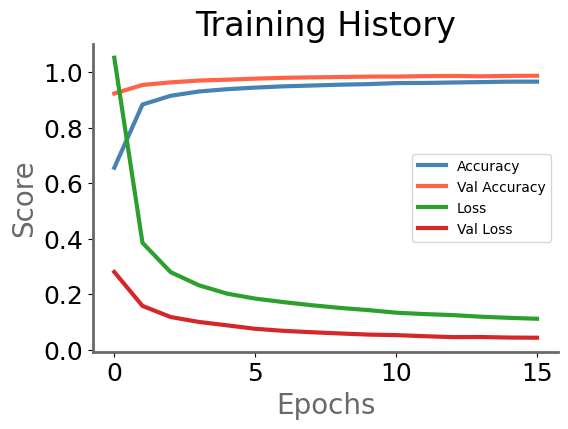

In [24]:
import matplotlib.pyplot as plt

# Afficher l'historique de l'entraînement
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Training History')
#plt.savefig('history.png')  # Sauvegarder l'image
plt.show()


### 6.3 - Plot results

  1/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


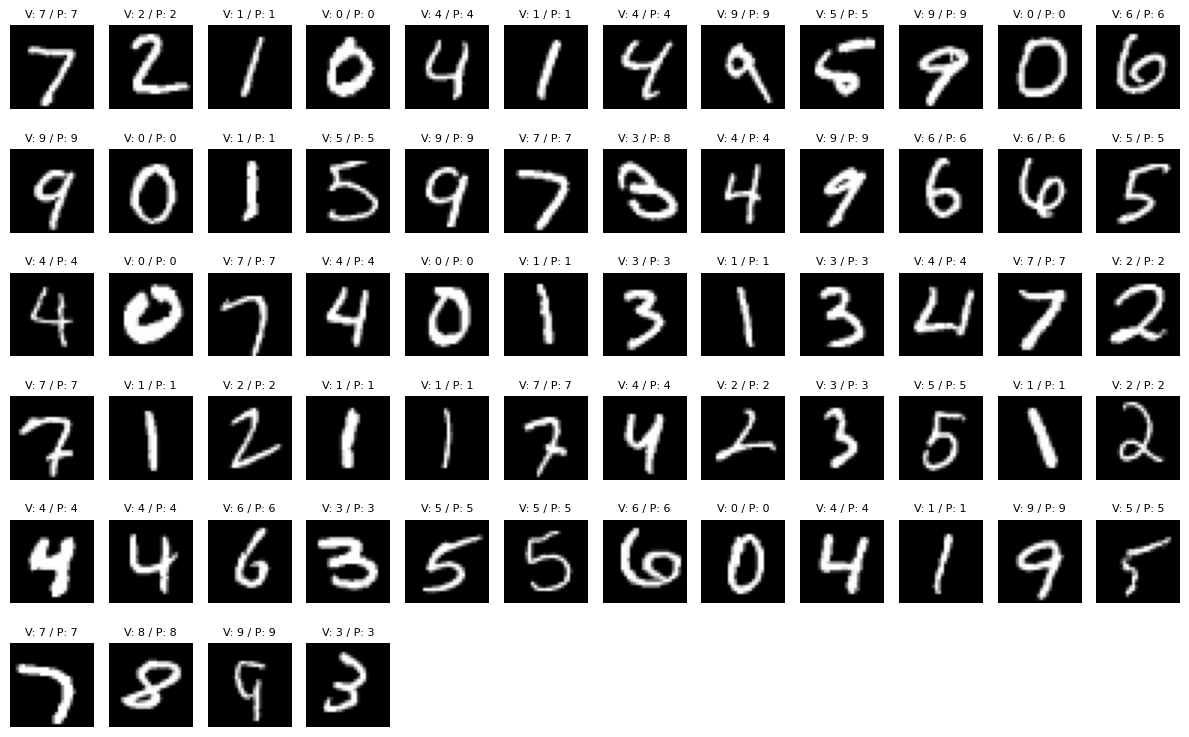

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Prédire les classes pour les images de test
y_sigmoid = model.predict(x_test)
y_pred = np.argmax(y_sigmoid, axis=-1)

# Afficher les images avec les vraies étiquettes et les prédictions
plt.figure(figsize=(12, 20))
for i in range(64):  # Affiche les 200 premières images
    plt.subplot(16, 12, i + 1)  # Crée une grille 16x12 pour afficher 200 images
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"V: {y_test[i]} / P: {y_pred[i]}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
#plt.savefig('predictions.png')  # Sauvegarder l'image sous '04-predictions.png'
plt.show()


### 6.4 - Plot some errors

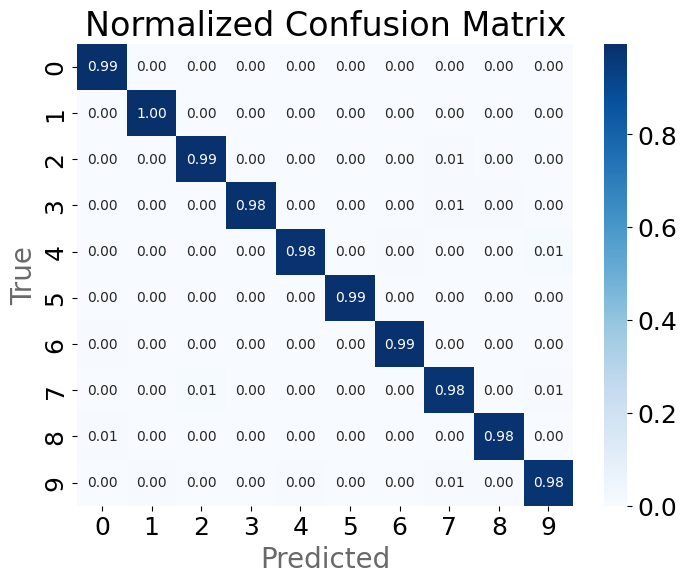

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
#plt.savefig('confusion-matrix.png')  # Sauvegarder l'image
plt.show()
